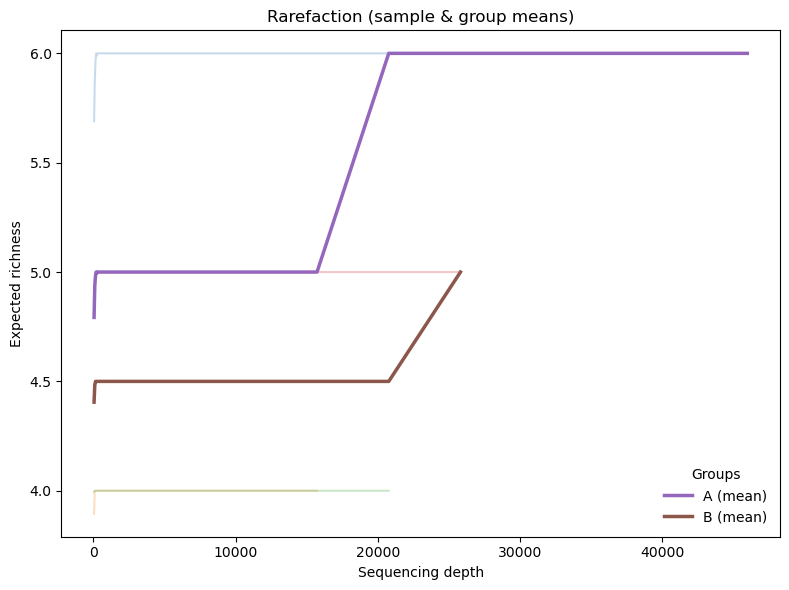

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Iterable, Optional, Dict, List

# ----------------------------- Core rarefaction -----------------------------
def rarefy_once(counts: np.ndarray, depth: int, rng: np.random.Generator) -> np.ndarray:
    """
    One rarefaction draw (without replacement) at the given depth for a single sample.
    Uses multivariate hypergeometric; counts must be non-negative integers.
    """
    total = counts.sum()
    if depth > total:
        raise ValueError(f"Depth {depth} exceeds total counts {total}.")
    if depth == 0:
        return np.zeros_like(counts)
    # True without-replacement sampling
    return rng.multivariate_hypergeometric(counts, depth)

def expected_richness(
    counts: np.ndarray,
    depths: Iterable[int],
    reps: int = 100,
    seed: Optional[int] = 0
) -> np.ndarray:
    """
    Monte-Carlo expected richness across depths for a single sample.
    Richness = number of taxa with count > 0 after rarefaction.
    """
    counts = np.asarray(counts, dtype=int)
    depths = np.asarray(list(depths), dtype=int)
    rng = np.random.default_rng(seed)
    out = np.empty(depths.size, dtype=float)

    total = counts.sum()
    depths = depths[depths <= total]   # guard against oversampling
    if depths.size == 0:
        return np.array([])

    for i, d in enumerate(depths):
        # replicate rarefaction and average richness
        rich = 0
        for _ in range(reps):
            subs = rarefy_once(counts, d, rng)
            rich += np.count_nonzero(subs)
        out[i] = rich / reps
    return out

# ----------------------------- Driver / plotting -----------------------------
def rarefaction_curves(
    df: pd.DataFrame,
    depths: Optional[Iterable[int]] = None,
    reps: int = 100,
    seed: int = 0,
) -> pd.DataFrame:
    """
    Compute expected richness for all samples in df (rows=samples, cols=taxa).
    Returns a tidy DataFrame with columns: sample, depth, richness.
    """
    if depths is None:
        max_depth = int(df.sum(axis=1).max())
        # Choose a sensible grid: denser at low depth
        step = max(1, max_depth // 50)
        depths = np.arange(step, max_depth + 1, step)

    records = []
    for sample, row in df.iterrows():
        vec = row.values.astype(int)
        # Remove negative/NaN
        vec[np.isnan(vec)] = 0
        if (vec < 0).any():
            raise ValueError(f"Negative counts found in sample '{sample}'.")
        rich = expected_richness(vec, depths, reps=reps, seed=seed)
        d_ok = np.asarray(list(depths))
        d_ok = d_ok[d_ok <= vec.sum()]
        for d, r in zip(d_ok, rich):
            records.append({"sample": sample, "depth": int(d), "richness": float(r)})
    return pd.DataFrame(records)

def plot_rarefaction(
    raref_df: pd.DataFrame,
    group_by: Optional[pd.Series] = None,
    title: str = "Rarefaction curves",
    alpha_lines: float = 0.25,
    lw_mean: float = 2.5,
    figsize=(8,6),
):
    """
    Plot per-sample curves (faint) and optional group means (bold).
    group_by: pd.Series indexed by sample name with categorical labels.
    """
    plt.figure(figsize=figsize)

    # per-sample
    for s, sdf in raref_df.groupby("sample"):
        plt.plot(sdf["depth"], sdf["richness"], alpha=alpha_lines)

    # optional group means
    if group_by is not None:
        # attach group labels
        gmap = group_by.to_dict()
        raref_df = raref_df.copy()
        raref_df["group"] = raref_df["sample"].map(gmap)
        # mean by (group, depth)
        gmean = (raref_df
                 .dropna(subset=["group"])
                 .groupby(["group", "depth"], as_index=False)["richness"]
                 .mean())
        for g, gdf in gmean.groupby("group"):
            gdf = gdf.sort_values("depth")
            plt.plot(gdf["depth"], gdf["richness"], label=f"{g} (mean)", linewidth=lw_mean)

        plt.legend(title="Groups", frameon=False)

    plt.xlabel("Sequencing depth")
    plt.ylabel("Expected richness")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ----------------------------- Example usage -----------------------------
if __name__ == "__main__":
    # Example: build a toy samples×taxa table
    # rows: S1..S4, cols: T1..T8
    df = pd.DataFrame(
        [[10,5,3,0,20,7,1,0],
         [ 5,0,0,0,12,2,1,0],
         [ 0,8,6,4, 0,0,0,3],
         [15,5,0,1, 5,2,0,0]],
        index=["S1","S2","S3","S4"],
        columns=[f"T{i}" for i in range(1,9)]
    ) * 1000

    # Optional metadata with groups
    meta = pd.DataFrame({"sample":["S1","S2","S3","S4"],
                         "Group":["A","A","B","B"]}).set_index("sample")

    # Depth grid (custom or auto)
    max_total = int(df.sum(axis=1).max())
    depths = np.unique(np.r_[np.arange(50, 501, 50),  # dense at low depth
                             np.linspace(600, max_total, 10, dtype=int)])

    raref_df = rarefaction_curves(df, depths=depths, reps=200, seed=42)
    # Save table if you like
    # raref_df.to_csv("rarefaction_curves.tsv", sep="\t", index=False)

    # Plot: per-sample + group means
    plot_rarefaction(raref_df, group_by=meta["Group"], title="Rarefaction (sample & group means)")


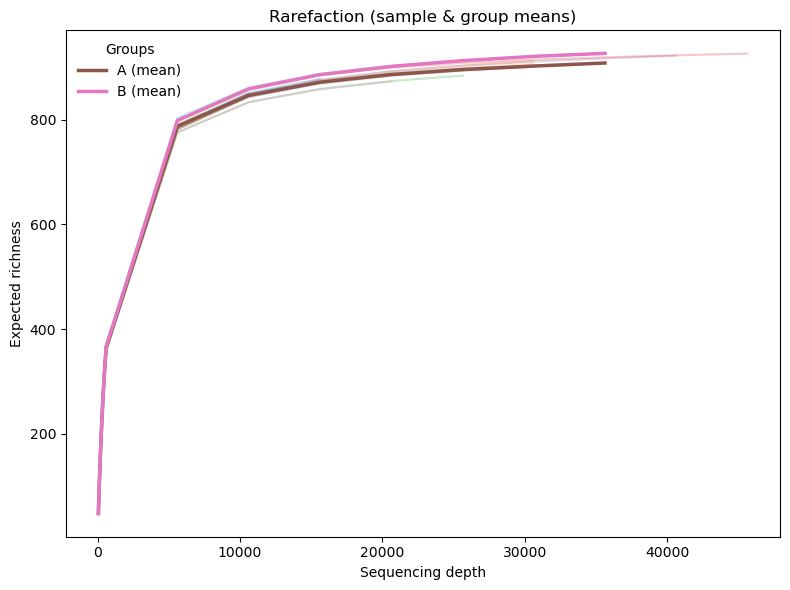

In [15]:
from scipy.stats import dirichlet

n_samples, n_taxa = 15, 1000
rng = np.random.default_rng(99)

# Concentration parameter controls evenness
alpha = rng.uniform(0.1, 2.0, size=n_taxa)

library_sizes = rng.integers(10000, 50000, size=n_samples)
counts = []

for depth in library_sizes:
    probs = dirichlet.rvs(alpha, random_state=rng)[0]
    sample_counts = rng.multinomial(depth, probs)
    counts.append(sample_counts)

df = pd.DataFrame(counts,
                  index=[f"S{i+1}" for i in range(n_samples)],
                  columns=[f"T{j+1}" for j in range(n_taxa)])

import pandas as pd
import numpy as np

# Assume df already exists (samples × taxa)
n_samples = df.shape[0]
rng = np.random.default_rng(123)

# Assign each sample randomly to a group
groups = rng.choice(["A", "B", "C"], size=n_samples)

# Build metadata table
metadata = pd.DataFrame({
    "sample": df.index,
    "Group": groups,
    # You can also add continuous covariates
    "Age": rng.integers(20, 60, size=n_samples),
    "Treatment": rng.choice(["control", "treated"], size=n_samples)
}).set_index("sample")

# Depth grid (custom or auto)
max_total = int(df.sum(axis=1).max())
depths = np.unique(np.r_[np.arange(50, 501, 50),  # dense at low depth
                         np.linspace(600, max_total, 10, dtype=int)])
raref_df = rarefaction_curves(df, depths=depths, reps=200, seed=42)
# Save table if you like
# raref_df.to_csv("rarefaction_curves.tsv", sep="\t", index=False)
# Plot: per-sample + group means
plot_rarefaction(raref_df, group_by=meta["Group"], title="Rarefaction (sample & group means)")

<Axes: xlabel='depth', ylabel='richness'>

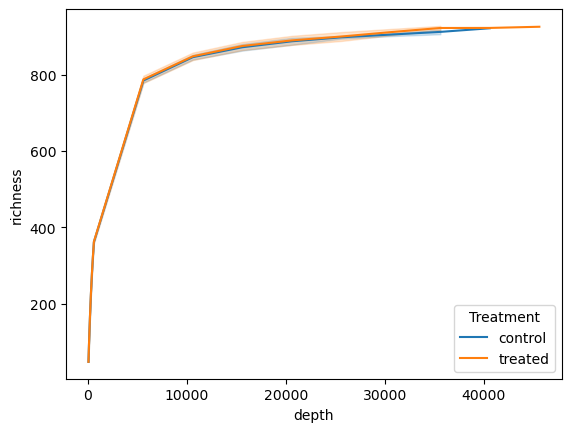

In [ ]:
import seaborn as sns

wide_df = raref_df.pivot(index='sample',columns='depth', values='richness')
long_df = wide_df.reset_index().melt(id_vars='sample', var_name='depth', value_name='richness')

group_d = metadata['Treatment'].to_dict()
long_df['Treatment'] = long_df['sample'].map(group_d)


#group_l = []
#for i, row in long_df.iterrows():
#    group_l.append(group_d[row['sample']])
#    
#long_df['Treatment'] = group_l

sns.lineplot(
    data=long_df,
    x='depth',
    y='richness',
    hue='Treatment',
    estimator='mean',
    errorbar='sd'
)

In [ ]:
group_d = metadata['Treatment'].to_dict()

group_l = []
for i, row in long_df.iterrows():
    group_l.append(group_d[row['sample']])
    
long_df['Treatment'] = group_l

sns.lineplot(
    data=long_df,
    x='depth',
    y='richness',
    hue='Treatment',
    estimator='mean',
    errorbar='sd'
)

In [68]:
group_s = metadata['Treatment'].to_dict()
group_s

{'S1': 'control',
 'S2': 'treated',
 'S3': 'control',
 'S4': 'treated',
 'S5': 'treated',
 'S6': 'control',
 'S7': 'treated',
 'S8': 'treated',
 'S9': 'control',
 'S10': 'treated',
 'S11': 'treated',
 'S12': 'control',
 'S13': 'control',
 'S14': 'control',
 'S15': 'control'}